# Helper Functions

In [1]:
def calc_box_limit(points):
    centroid_width = points[0]
    centroid_height = points[1]
    width_offset = points[2]//2
    height_offset = points[3]//2
    
    box_limits = (centroid_width - width_offset,
                  centroid_width + width_offset,
                  centroid_height - height_offset,
                  centroid_height + height_offset)
    
    return box_limits

In [2]:
def return_duplicate_indices(box_limits):

    discard = []

    for index, boundary in enumerate(box_limits):

        # If found within ANOTHER box, throw it away, set keep to False
        for outer_index, outer_boundary in enumerate(box_limits):
            if outer_index != index:
                if boundary[0] >= outer_boundary[0] and\
                   boundary[1] <= outer_boundary[1] and\
                   boundary[2] >= outer_boundary[2] and\
                   boundary[3] <= outer_boundary[3]:
                    print('Found duplicate! {} inside of {}'.format(boundary, outer_boundary))
                    discard.append(index)
                    break
    return discard

# Import Relevant Modules

In [3]:
import os
import cv2
import numpy
from IPython.display import Image
from IPython.core.display import HTML 

# Set up a configuration
Configuration includes important variables such as image dimensions, HSV range settings, threshhold for filtering, image directory, and whether or not to remove duplicates.

In [4]:
config = {'display-height': 700,
         'display-width': 1200,
         'image-width':1920,
         'image-height':939,
         'hue-lower': 50,
         'hue-upper': 120,
         'sat-lower': 40,
         'sat-upper': 255,
         'value-lower': 140,
         'value-upper': 255,
         'image-dir': './data/',
         'area-threshhold': 1000,
         'remove-dupes': True}

# Read in files
Create a list of paths pointing to images we are using

In [5]:
files = [config['image-dir'] + filename for filename in os.listdir(config['image-dir'])]

# Set a single image path for testing
For now I will process one at a time

In [6]:
# Files 14 tested for duplicate
test_img_path = files[14]

# Preview test image in `jupyter notebooks`

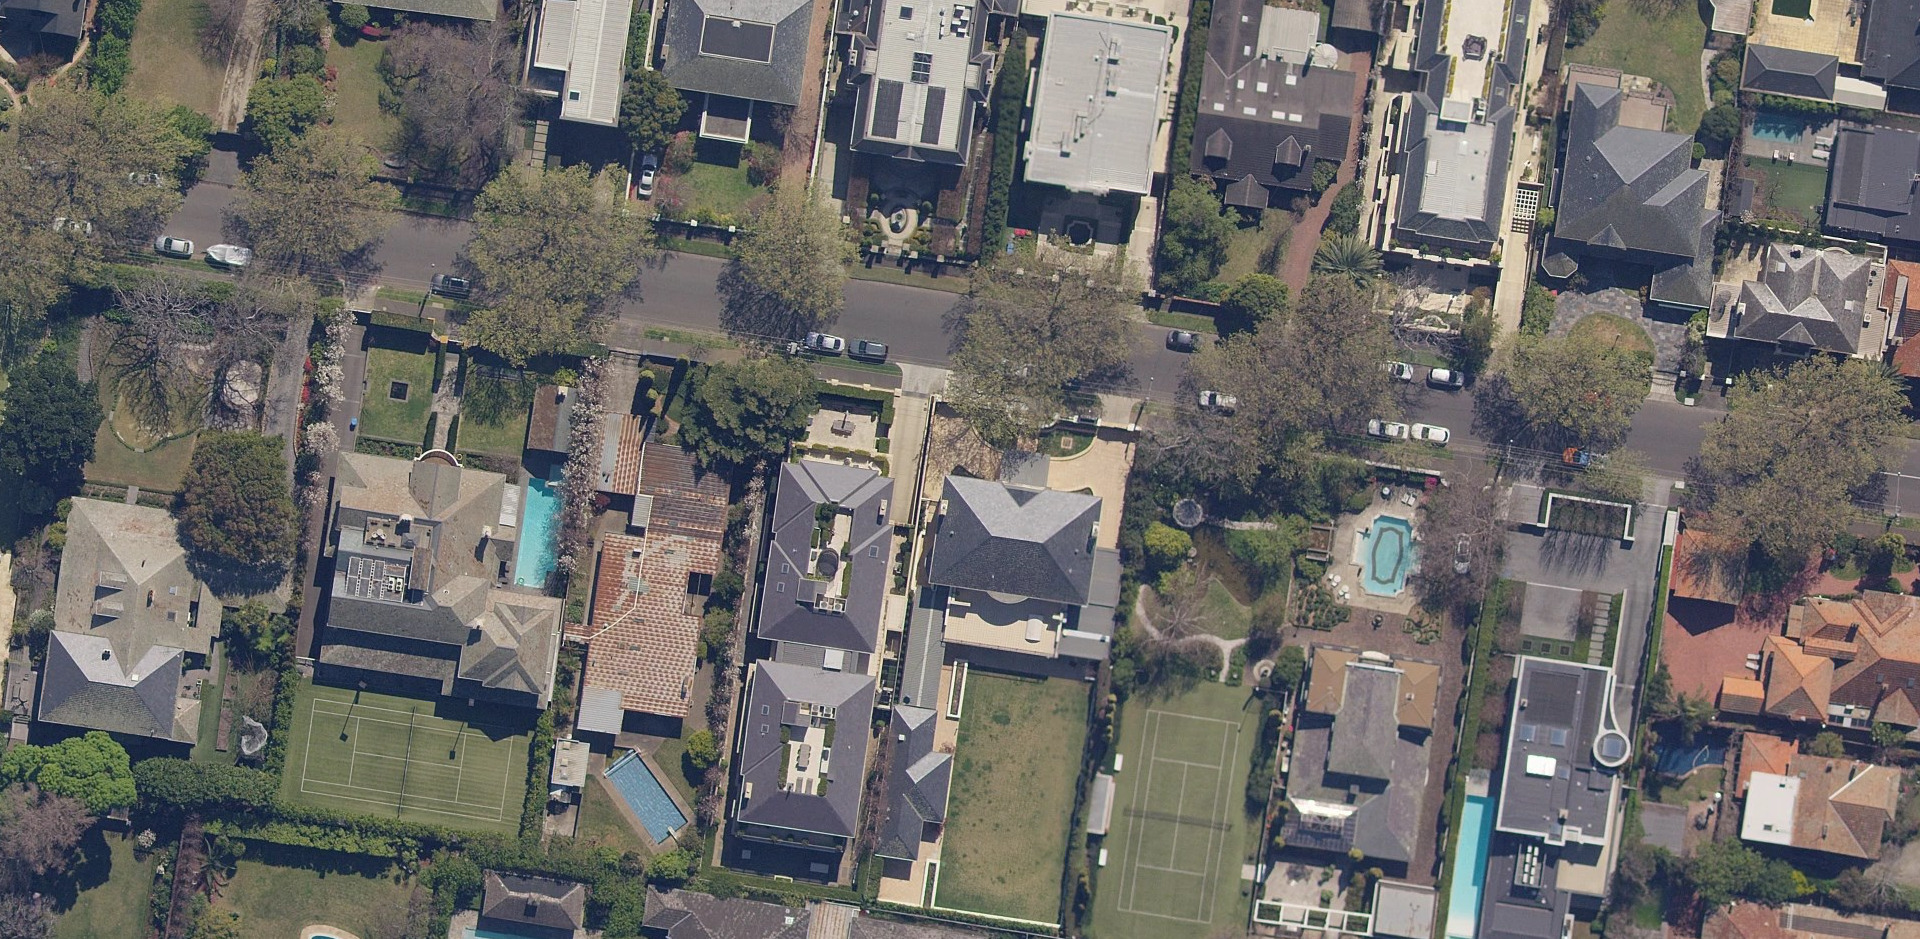

In [7]:
Image(filename = test_img_path, 
      width = config['display-width'], 
      height = config['display-height'])

# Create image object, create colour mask

In [8]:
# Read in image
image = cv2.imread(test_img_path)

# Convert Image to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create mask in HSV
mask = cv2.inRange(hsv, 
                   (config['hue-lower'], config['sat-lower'], config['value-lower']), 
                   (config['hue-upper'], config['sat-upper'], config['value-upper']))

# Slice the BLUE
imask = mask>0
pool_blue = numpy.zeros_like(image, 
                             numpy.uint8)
pool_blue[imask] = image[imask]

_, contours, _ = cv2.findContours(mask, 
                                  cv2.RETR_TREE, 
                                  cv2.CHAIN_APPROX_SIMPLE)

# Process contours
- Calculating area of each contour found
- Discard contour if not met by area condition in config dictionary
- Remove duplicates by condition in config dictionary (True/False)

In [9]:
# Find the contours within the area threshhold defined in config, and add to found_these
found_these = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = w * h
    if area >= config['area-threshhold']:
        found_these.append((x, y, w, h))

# Calculate Box Limits
box_limits = list(map(calc_box_limit, found_these))
    
if config['remove-dupes'] is True:

    # Find indices of duplicate boxes (boxes within boxes)
    discard = return_duplicate_indices(box_limits)

    # Calculate final contours
    final_contours = [item for index, item in enumerate(found_these) if index not in discard]
else:
    discard=[]
    final_contours=found_these

# Paint boxes onto image
for c in final_contours:
    x, y, w, h = c[0], c[1], c[2], c[3]
    cv2.rectangle(pool_blue,
                  (x,y),
                  (x + w, y + h),
                  (0, 255, 0),2)

Found duplicate! (1353, 1387, 497, 555) inside of (1340, 1388, 484, 556)
Found duplicate! (1363, 1387, 508, 556) inside of (1340, 1388, 484, 556)


# Save result to `.png`, also display result in `jupyter notebooks`

In [10]:
cv2.imwrite('test_result.png', 
            pool_blue)

True

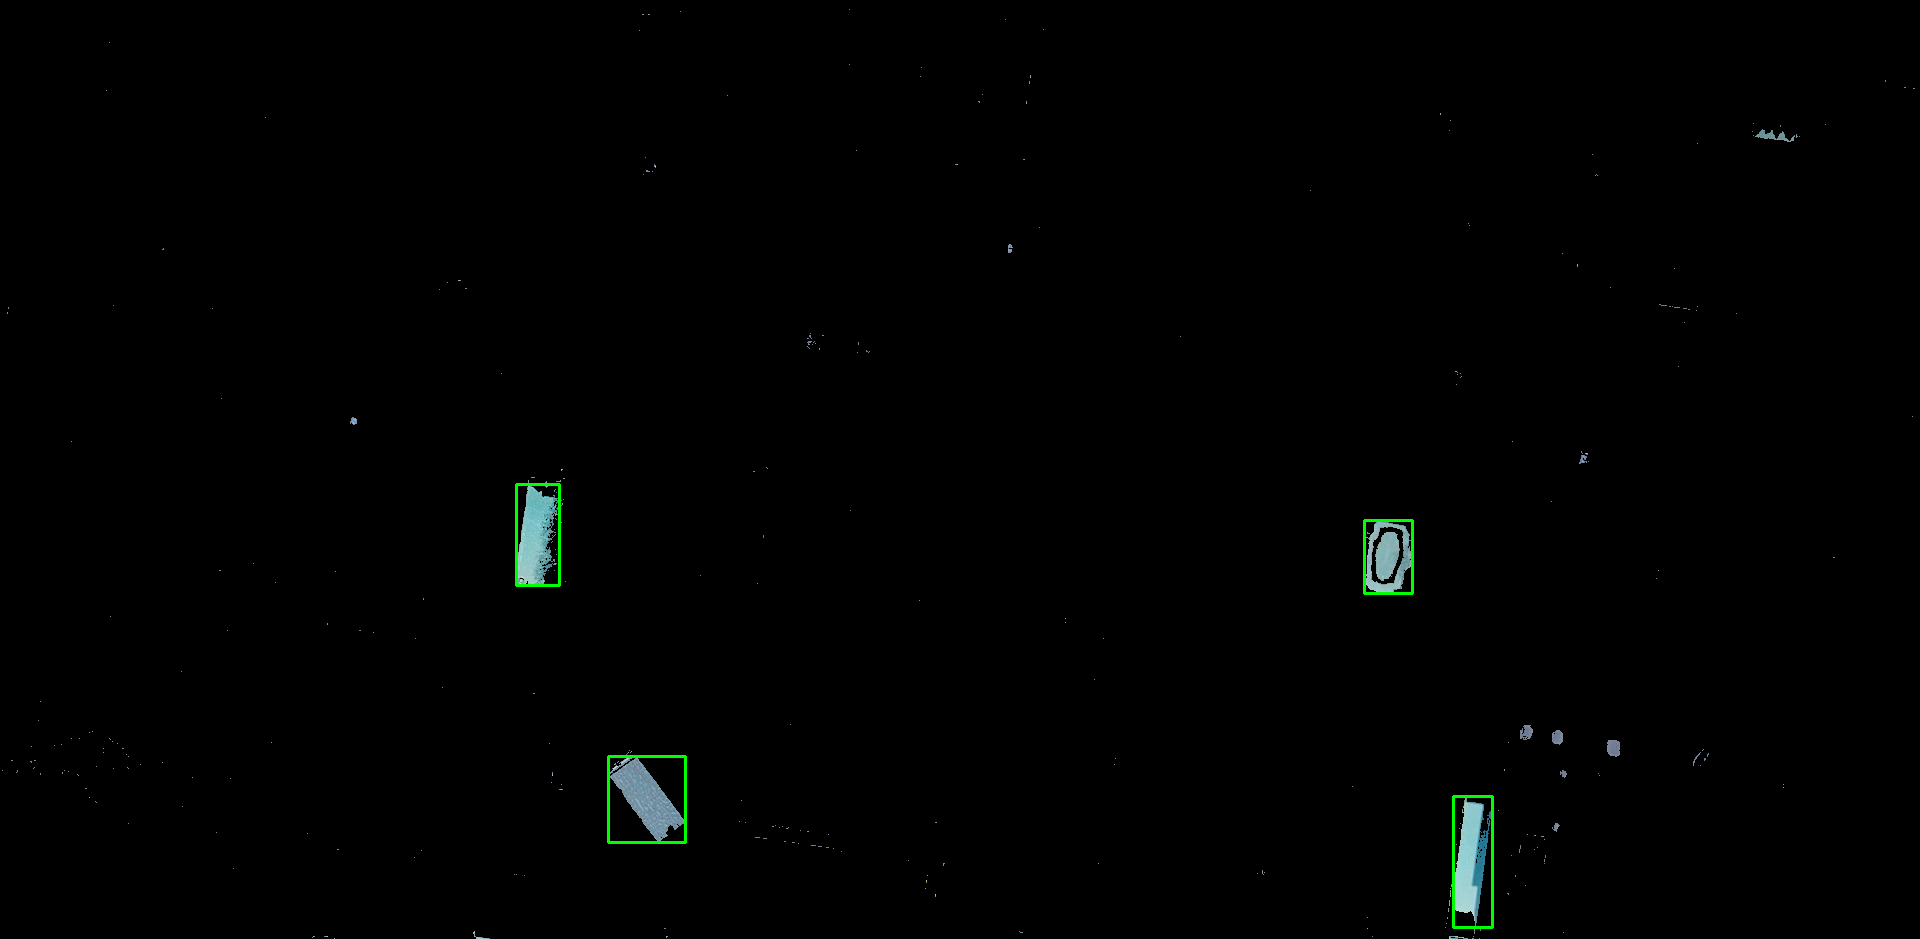

In [11]:
Image(filename = './test_result.png', 
      width = config['display-width'], 
      height = config['display-height'])

# Verify Values
Just to make sure everything checks out

### Pixel coordinates detected in format (pixel x pos, pixel y pos, pixel width, pixel height)

In [12]:
found_these

[(1453, 796, 39, 131),
 (608, 756, 77, 86),
 (1364, 520, 48, 73),
 (1370, 526, 35, 59),
 (1375, 532, 25, 49),
 (516, 484, 43, 101)]

### The upper and lower limits of the detections in pixels

In [13]:
box_limits

[(1434, 1472, 731, 861),
 (570, 646, 713, 799),
 (1340, 1388, 484, 556),
 (1353, 1387, 497, 555),
 (1363, 1387, 508, 556),
 (495, 537, 434, 534)]

### The detections (indices) discarded as a result of the duplication filter

In [14]:
discard

[3, 4]

### The final contours to be used after filters have been applied, in the same format as `found_these`

In [15]:
final_contours

[(1453, 796, 39, 131),
 (608, 756, 77, 86),
 (1364, 520, 48, 73),
 (516, 484, 43, 101)]

# Reverse geocode using relative positions on image
This part will involve several steps:
1. Find the **real world coordinates** of the bottom left and top right corner of the image, as provided in the image name (file path)
2. Calculate the longitude and latitude **offsets** (width and length of image converted to longitude/latitude)
3. Calculate the **longitude/latitude coordinates** of bounding box detections using the offsets calculated in step 2, image dimensions and pixel coordinates of bounding box centroids.

### Step 1 

In [16]:
def find_long_lat_from_filepath(image_path):
    
    filename = image_path.split('/')[-1]
    split = filename.split('_')
    bottom_left_corner = [float(split[4] + '.' + split[5]), float(split[6] + '.' + split[7])]
    top_right_corner = [float(split[8] + '.' + split[9]), float(split[10] + '.' + split[11])]
    
    return bottom_left_corner, top_right_corner

In [17]:
bottom_left, top_right = find_long_lat_from_filepath(test_img_path)

### Step 2

In [18]:
long_diff = top_right[0] - bottom_left[0]
lat_diff = top_right[1] - bottom_left[1]

print('The longitude offset is {}. \nThe latitude offset is {}'.\
      format(long_diff, lat_diff))

The longitude offset is 0.0025800000000231194. 
The latitude offset is 0.0009900000000016007


### Step 3

In [19]:
coords_of_pools = [((contour[0] / config['image-width'] * long_diff) + bottom_left[0],
                   top_right[1] - (contour[1] / config['image-height'] * lat_diff)) 
                   for contour in final_contours]

In [20]:
coords_of_pools

[(144.98812246875, -37.90068923322684),
 (144.986987, -37.90064706070288),
 (144.988002875, -37.900398242811505),
 (144.98686337499998, -37.90036028753994)]